# Using ZNE to compute the energy landscape of a variational circuit with Qiskit

This tutorial shows an example in which the energy landscape for a two-qubit variational circuit is explored with and without error mitigation, using Qiskit as our frontend.

In [49]:
import matplotlib.pyplot as plt
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error

from mitiq.zne import mitigate_executor
from mitiq.zne.inference import RichardsonFactory

## Defining the ideal variational circuit in Qiskit 

We define a function which returns a simple two-qubit variational circuit depending on a single parameter  $\gamma$ ("gamma").

In [50]:
def variational_circuit(gamma: float) -> QuantumCircuit:
    """Returns a two-qubit circuit for a given variational parameter.

    Args:
        gamma: The variational parameter.

    Returns:
        The two-qubit circuit with a fixed gamma.
    """
    circuit = QuantumCircuit(2)
    circuit.rx(gamma, 0)
    circuit.cnot(0, 1)
    circuit.rx(gamma, 1)
    circuit.cnot(0, 1)
    circuit.rx(gamma, 0)
    
    return circuit


We can visualize the circuit for a particular $\gamma$ as follows.

In [51]:
circuit = variational_circuit(gamma=np.pi)
circuit.draw()

┌───────┐                   ┌───────┐
q_0: ┤ Rx(π) ├──■─────────────■──┤ Rx(π) ├
     └───────┘┌─┴─┐┌───────┐┌─┴─┐└───────┘
q_1: ─────────┤ X ├┤ Rx(π) ├┤ X ├─────────
              └───┘└───────┘└───┘

## Defining the executor functions with and without noise
To use error mitigation methods in Mitiq, we define an executor function which computes the expectation value of a simple Hamiltonian $H=Z \otimes Z$, i.e., Pauli-$Z$ on each qubit. To compare to the noiseless result, we define both a noiseless and a noisy executor below.

In [52]:
# observable to measure
z = np.diag([1, -1])
hamiltonian = np.kron(z, z)

def noiseless_executor(circuit: QuantumCircuit) -> float:
    """Simulates the execution of a circuit without noise.

    Args:
        circuit: The input circuit.

    Returns:
        The expectation value of the ZZ observable.
    """
    # avoid mutating the input circuit
    circ = circuit.copy()
    circ.save_density_matrix()

    # execute experiment without noise
    job = qiskit.execute(
        experiments=circ,
        backend=qiskit.Aer.get_backend("aer_simulator_density_matrix"),
        noise_model=None,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        shots=1,
    )
    rho = job.result().data()["density_matrix"]

    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation 
    


# strength of noise channel
noise_level = 0.04

def executor_with_noise(circuit: QuantumCircuit) -> float:
    """Simulates the execution of a circuit with depolarizing noise.

    Args:
        circuit: The input circuit.

    Returns:
        The expectation value of the ZZ hamiltonian.
    """
    # avoid mutating the input circuit
    circ = circuit.copy()
    circ.save_density_matrix()
    
    # Initialize qiskit noise model. In this case a
    # depolarizing noise model with the same noise strength for each
    # gate of the standard IBM basis
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 1), ["u1", "u2", "u3"]
    )
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 2), ["cx"]
    ) 
    

    # execute experiment with depolarizing noise
    job = qiskit.execute(
        experiments=circ,
        backend=qiskit.Aer.get_backend("aer_simulator_density_matrix"),
        noise_model=noise_model,
        basis_gates=noise_model.basis_gates + ["save_density_matrix"],
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        shots=1,
    )
    rho = job.result().data()["density_matrix"]

    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation 


**Note:** The above code block uses depolarizing noise, but any Qiskit `NoiseModel` can be substituted in.


## Computing the landscape without noise

We now compute the energy landscape $\langle H \rangle(\gamma) =\langle Z \otimes Z \rangle(\gamma)$ on the noiseless simulator.

**Note:** The remaining code in this tutorial is generic and does not depend on a particular frontend.

In [53]:
gammas = np.linspace(0, 2 * np.pi, 50)
noiseless_expectations = [noiseless_executor(variational_circuit(g)) for g in gammas]

The following code plots the values for visualization.

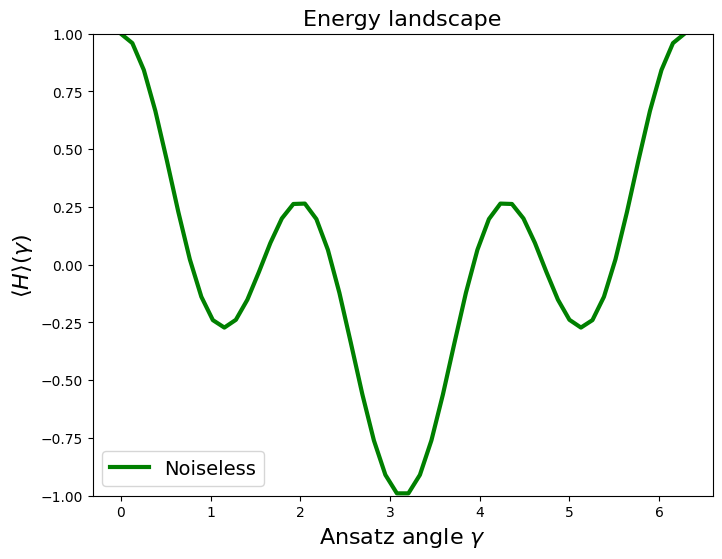

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.title("Energy landscape", fontsize=16)
plt.xlabel(r"Ansatz angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1, 1);
plt.show()

## Computing the unmitigated landscape
We now compute the unmitigated energy landscape $\langle H \rangle(\gamma) =\langle Z \otimes Z \rangle(\gamma)$
in the following code block.

In [55]:
gammas = np.linspace(0, 2 * np.pi, 50)
expectations = [executor_with_noise(variational_circuit(g)) for g in gammas]

The following code plots these values for visualization along with the noiseless landscape.

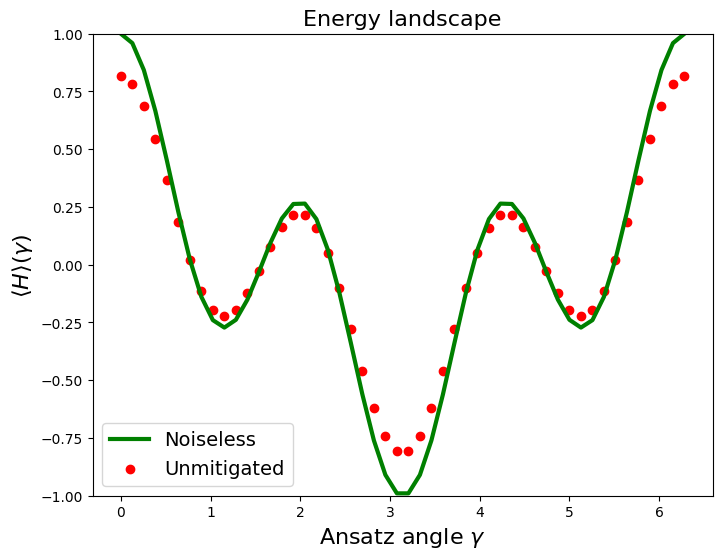

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.scatter(gammas, expectations, color="r", label="Unmitigated")
plt.title(rf"Energy landscape", fontsize=16)
plt.xlabel(r"Ansatz angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1, 1);
plt.show()

## Computing the mitigated landscape
We now repeat the same task but use Mitiq to mitigate errors.
We initialize a RichardsonFactory with scale factors `[1, 3, 5]` and we get a mitigated executor as follows.

In [57]:
fac = RichardsonFactory(scale_factors=[1, 3, 5])
mitigated_executor = mitigate_executor(executor_with_noise, factory=fac)

We then run the same code above to compute the energy landscape, but this time use the ``mitigated_executor`` instead of just the executor.

In [58]:
mitigated_expectations = [mitigated_executor(variational_circuit(g)) for g in gammas]

Let us visualize the mitigated landscape alongside the unmitigated and noiseless landscapes.

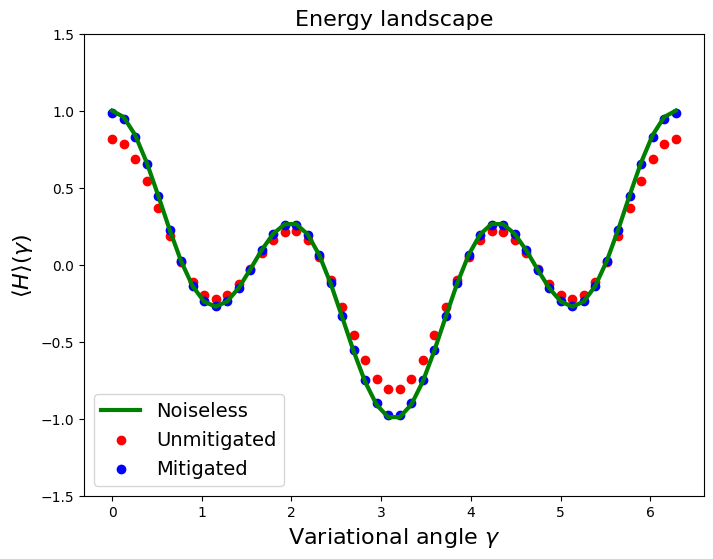

In [59]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.scatter(gammas, expectations, color="r", label="Unmitigated")
plt.scatter(gammas, mitigated_expectations, color="b", label="Mitigated")
plt.title(rf"Energy landscape", fontsize=16)
plt.xlabel(r"Variational angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1.5, 1.5);
plt.show()

Noise usually tends to flatten expectation values towards a constant. Therefore error mitigation 
can be used to increase the visibility the landscape and this fact can simplify the energy minimization 
which is required in most variational algorithms such as VQE or QAOA.

We also observe that the minimum of mitigated energy approximates well the theoretical ground state which is equal to $-1$. Indeed:

In [60]:
print(f"Minimum of the noisy landscape: {round(min(expectations), 3)}")
print(f"Minimum of the mitigated landscape: {round(min(mitigated_expectations), 3)}")
print(f"Theoretical groud state energy: {min(np.linalg.eigvals(hamiltonian))}")

Minimum of the noisy landscape: -0.807
Minimum of the mitigated landscape: -0.976
Theoretical groud state energy: -1.0
